In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold

## Reading data

In [3]:
data = 'wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [4]:
!wget $data

--2023-10-08 21:41:59--  http://wget/
Resolving wget (wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘wget’
--2023-10-08 21:41:59--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1,41M  2,02MB/s    in 0,7s    

2023-10-08 21:42:00 (2,02 MB/s) - ‘data.csv’ saved [1475504/1475504]

FINISHED --2023-10-08 21:42:00--
Total wall clock time: 1,5s
Downloaded: 1 files, 1,4M in 0,7s (2,02 MB/s)


In [5]:
df_raw = pd.read_csv('data.csv')
df_raw.head() 

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Data preparation

In [6]:
df = df_raw[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type',
             'Vehicle Style','highway MPG','city mpg','MSRP']]
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [7]:
df = df.fillna(0)
df = df.rename(columns={"msrp": "price"})
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [8]:
numerical_cols = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical_cols = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']

In [9]:
df[numerical_cols] = df[numerical_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

**Make price a binary variable**

In [10]:
mean_price = df['price'].mean()
df['above_average'] = np.where(df['price'] > mean_price,1,0)
df['above_average'].value_counts(normalize=True)

0    0.725617
1    0.274383
Name: above_average, dtype: float64

**Setting up the validation framework**

* Perform the train/validation/test split with Scikit-Learn

In [20]:
RANDOM_SEED = 1

In [21]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=RANDOM_SEED)

In [22]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [23]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [24]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

df_train = df_train.drop(['above_average', 'price'], axis=1)
df_val= df_val.drop(['above_average', 'price'], axis=1)
df_test = df_test.drop(['above_average', 'price'], axis=1)

## Question 1: ROC AUC feature importance

In [34]:
auc_scores = []
for col in numerical_cols:
    y = df_full_train['above_average']
    num_col = df_full_train[col]
    auc_score = roc_auc_score(y, num_col)
    if auc_score < 0.5:
        auc_score = roc_auc_score(y, -num_col)
    result_dict = {
                    'num_col': col,
                    'auc': auc_score}
    auc_scores.append(result_dict)

auc_scores_df = pd.DataFrame(auc_scores)

In [35]:
auc_scores_df

,num_col,auc
0,engine_hp,0.916607
1,engine_cylinders,0.766852
2,highway_mpg,0.631963
3,city_mpg,0.672562


Q1: engine_hp has the highest AUC

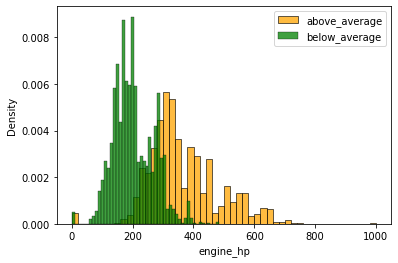

In [47]:
sns.histplot(df_full_train.engine_hp[df_full_train.above_average == 1],
             stat='density', bins=50, color='orange', label='above_average')
sns.histplot(df_full_train.engine_hp[df_full_train.above_average == 0],
             stat='density', bins=50, color='green', label='below_average')

plt.legend()
plt.show()

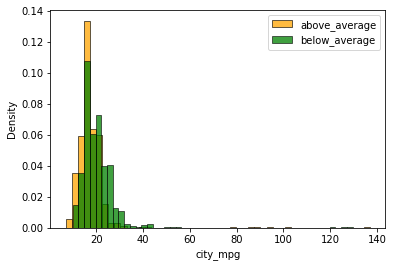

In [46]:
sns.histplot(df_full_train.city_mpg[df_full_train.above_average == 1],
             stat='density', bins=50, color='orange', label='above_average')
sns.histplot(df_full_train.city_mpg[df_full_train.above_average == 0],
             stat='density', bins=50, color='green', label='below_average')

plt.legend()
plt.show()

We can even see on the plots that engine_hp can really separate our target variable

## Question 2: Training the model

In [50]:
def prepare_df(df_train, df_val):
    dv = DictVectorizer(sparse=False)
    
    df_train = df_train[categorical_cols + numerical_cols]
    df_val = df_val[categorical_cols + numerical_cols]

    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    return X_train, X_val

In [51]:
def train_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    print (f'AUC score {round(roc_auc_score(y_val, y_pred),4)}')

In [54]:
X_train, X_val = prepare_df(df_train, df_val)
train_model(X_train, y_train, X_val, y_val)

AUC score 0.9766


Q2: AUC of this model on the validation dataset is 0.979

## Question 3: Precision and Recall

In [57]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

In [58]:
y_pred

array([0.64240495, 0.01506024, 0.48519413, ..., 0.00528823, 0.99998724,
       0.09593936])

In [97]:
scores = []

thresholds = np.arange(0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [98]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

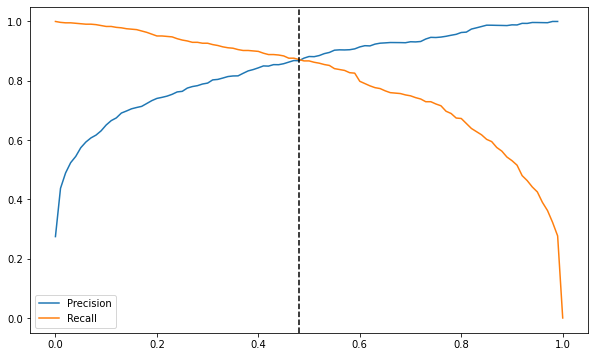

In [99]:
plt.subplots(1, figsize=(10,6))
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
intersection = df_scores[round(df_scores['precision'],2) == round(df_scores['recall'],2)]['threshold'].values
plt.axvline(x=intersection, color="black", linestyle="--")
plt.legend()

In [100]:
df_scores[round(df_scores['precision'],2) == round(df_scores['recall'],2)]['threshold']

48    0.48
Name: threshold, dtype: float64

Q3: at 0.48 precision and recall intersects

In [71]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

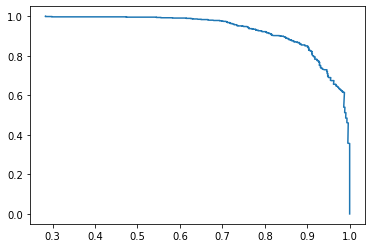

In [87]:
plt.plot(precision, recall)

## Question 4: F1-score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
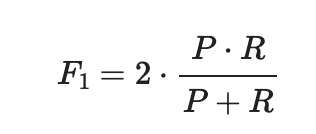

Where P is precision and R is recall.

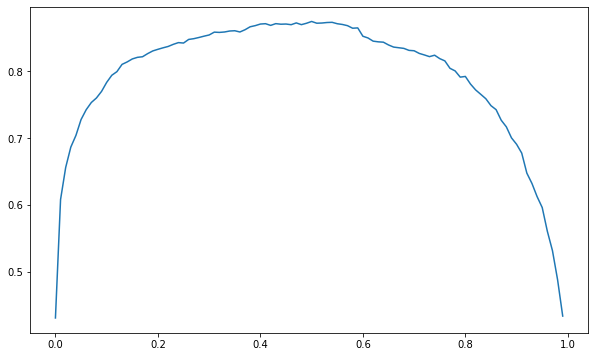

In [101]:
df_scores['f1'] = (2*df_scores['precision']*df_scores['recall'])/(df_scores['precision']+df_scores['recall'])

plt.figure(figsize=(10, 6))
plt.plot(df_scores['threshold'], df_scores['f1'])

In [102]:
df_scores.sort_values(by='f1', ascending=False)

,threshold,tp,fp,fn,tn,precision,recall,f1
50,0.50,567,76,87,1653,0.881804,0.866972,0.874325
54,0.54,557,65,97,1664,0.895498,0.851682,0.873041
53,0.53,559,68,95,1661,0.891547,0.854740,0.872756
47,0.47,573,87,81,1642,0.868182,0.876147,0.872146
52,0.52,562,73,92,1656,0.885039,0.859327,0.871994
...,...,...,...,...,...,...,...,...
97,0.97,237,1,417,1728,0.995798,0.362385,0.531390
98,0.98,211,0,443,1729,1.000000,0.322630,0.487861
99,0.99,181,0,473,1729,1.000000,0.276758,0.433533
0,0.00,654,1729,0,0,0.274444,1.000000,0.430688


Q4: At 0.5 f1-score is the highest (0.52 is the closest)

## Question 5: 5-Fold CV

In [104]:
from tqdm.auto import tqdm

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

In [107]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold.get_n_splits(df_full_train)

5

In [112]:
def train_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

In [116]:
auc_scores = []

for i, (train_index, test_index) in enumerate(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_index]
    df_val = df_full_train.iloc[test_index]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    df_train = df_train.drop(['above_average', 'price'], axis=1)
    df_val= df_val.drop(['above_average', 'price'], axis=1)
    
    X_train, X_val = prepare_df(df_train, df_val)
    auc = train_model(X_train, y_train, X_val, y_val)
    
    auc_scores.append(auc)

In [117]:
print('%.3f +- %.3f' % (np.mean(auc_scores), np.std(auc_scores)))

0.978 +- 0.001


In [118]:
np.std(auc_scores)

0.0010407672156355376

Q5: Standard deviation is 0.001 (closest to 0.003)

## Question 6: Hyperparemeter Tuning

In [119]:
def train_model(X_train, y_train, X_val, y_val, C):
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

In [120]:
from tqdm.auto import tqdm
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        df_train = df_train.drop(['above_average', 'price'], axis=1)
        df_val= df_val.drop(['above_average', 'price'], axis=1)

        X_train, X_val = prepare_df(df_train, df_val)
        auc = train_model(X_train, y_train, X_val, y_val, C=C)

        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.977 +- 0.001
C=10 0.980 +- 0.003


Q6: C=10 leads to the best mean score of auc